# create database from scratch

In [1]:
from flask import Flask
from flask_sqlalchemy import SQLAlchemy
from faker import Faker
from datetime import datetime, timedelta
import os
import random
import base64
import pytz

# use australian sydney time zone
timezone = pytz.timezone('Australia/Sydney')

# filename is: ./database.db
base_dir = os.getcwd()
db_path = os.path.join(base_dir, 'database.db')

# initialize
faker = Faker('en_AU')
db = SQLAlchemy()
app = Flask(__name__)

app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///' + db_path
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False

db.init_app(app)

In [2]:
# 3 tables: student, supervisor, partner
class Student(db.Model):
    __tablename__ = 'student'
    __table_args__ = {"extend_existing": True}

    student_id = db.Column(db.Integer, primary_key=True)
    username = db.Column(db.String, nullable=False, unique=True)
    first_name = db.Column(db.String, nullable=False)
    last_name = db.Column(db.String, nullable=False)
    email = db.Column(db.String, nullable=False, unique=True)
    password = db.Column(db.String, nullable=False)
    avatar = db.Column(db.String, nullable=False)

    qualification = db.Column(db.String, nullable=False)
    school_name = db.Column(db.String, nullable=False)
    major = db.Column(db.String, nullable=False)
    skills = db.Column(db.String, nullable=False)
    strength = db.Column(db.String, nullable=False)

    # !!!!
    resume_url = db.Column(db.String, nullable=True, default=None)


class Supervisor(db.Model):
    __tablename__ = 'supervisor'
    __table_args__ = {"extend_existing": True}

    supervisor_id = db.Column(db.Integer, primary_key=True)
    username = db.Column(db.String, nullable=False, unique=True)
    first_name = db.Column(db.String, nullable=False)
    last_name = db.Column(db.String, nullable=False)
    email = db.Column(db.String, nullable=False, unique=True)
    password = db.Column(db.String, nullable=False)
    avatar = db.Column(db.String, nullable=False)

    qualification = db.Column(db.String, nullable=False)
    school_name = db.Column(db.String, nullable=False)
    skills = db.Column(db.String, nullable=False)


class Partner(db.Model):
    __tablename__ = 'partner'
    __table_args__ = {"extend_existing": True}

    partner_id = db.Column(db.Integer, primary_key=True)
    username = db.Column(db.String, nullable=False, unique=True)
    first_name = db.Column(db.String, nullable=False)
    last_name = db.Column(db.String, nullable=False)
    email = db.Column(db.String, nullable=False, unique=True)
    password = db.Column(db.String, nullable=False)
    avatar = db.Column(db.String, nullable=False)

    company = db.Column(db.String, nullable=False)
    position = db.Column(db.String, nullable=False)
    description = db.Column(db.String, nullable=False)

################################################################

# the partner creates the project
class Project(db.Model):
    __tablename__ = 'project'
    __table_args__ = {"extend_existing": True}

    # each partner may have multiple project
    project_id = db.Column(db.Integer, primary_key=True)
    partner_id = db.Column(db.Integer, db.ForeignKey('partner.partner_id'), nullable=False)

    title = db.Column(db.String, nullable=False)
    description = db.Column(db.String, nullable=False)

    # the project detail
    problem_statement = db.Column(db.String, nullable=False)
    desired_outcomes = db.Column(db.String, nullable=False)
    required_skills = db.Column(db.String, nullable=False)
    deliverables = db.Column(db.String, nullable=False)

    # timestamp for project creation
    created_at = db.Column(db.DateTime, nullable=False, default=datetime.now)

    # the partner decides for supervisor id,
    # then the supervisor decides for student id
    # these two values are null at beginning
    supervisor_id = db.Column(db.Integer, db.ForeignKey('supervisor.supervisor_id'), nullable=True, default=None)
    supervisor_being_assigned_at = db.Column(db.DateTime, nullable=True, default=datetime.now, onupdate=datetime.now)

    student_id = db.Column(db.Integer, db.ForeignKey('student.student_id'), nullable=True, default=None)
    student_being_assigned_at = db.Column(db.DateTime, nullable=True, default=datetime.now, onupdate=datetime.now)

    # project has a flag: is_open, in_progres, closed
    status = db.Column(db.Enum('is_open', 'in_progress', 'closed'), nullable=False, default='is_open')

# the student express interests, and attach a sentence
class StudentInterestExpress(db.Model):
    __tablename__ = 'student_interest_express'
    __table_args__ = {"extend_existing": True}

    # each student may have multiple interests to multiple projects
    student_interest_express_id = db.Column(db.Integer, primary_key=True)
    student_id = db.Column(db.Integer, db.ForeignKey('student.student_id'), nullable=False)
    project_id = db.Column(db.Integer, db.ForeignKey('project.project_id'), nullable=False)
    reason = db.Column(db.String, nullable=False)
    last_updated_at = db.Column(db.DateTime, nullable=False, default=datetime.now, onupdate=datetime.now)

# the supervisor also need to express interests to link project with student,
# also attach a sentence
class SupervisorInterestExpress(db.Model):
    __tablename__ = 'supervisor_interest_express'
    __table_args__ = {"extend_existing": True}

    # each supervisor may have multiple interests to multiple projects
    supervisor_interest_express_id = db.Column(db.Integer, primary_key=True)
    supervisor_id = db.Column(db.Integer, db.ForeignKey('supervisor.supervisor_id'), nullable=False)
    project_id = db.Column(db.Integer, db.ForeignKey('project.project_id'), nullable=False)
    reason = db.Column(db.String, nullable=False)
    last_updated_at = db.Column(db.DateTime, nullable=False, default=datetime.now, onupdate=datetime.now)

# the student reports for progress for the project,
# recorded with date, and content, and will be commented by the partner only
class ProjectProgress(db.Model):
    __tablename__ = 'project_progress'
    __table_args__ = {"extend_existing": True}

    # each student may have multiple progress for a project
    project_progress_id = db.Column(db.Integer, primary_key=True)
    project_id = db.Column(db.Integer, db.ForeignKey('project.project_id'), nullable=False)
    student_id = db.Column(db.Integer, db.ForeignKey('student.student_id'), nullable=False)

    # the student can upload some text content, and a file url,
    # url can be null
    content = db.Column(db.String, nullable=False)
    file_url = db.Column(db.String, nullable=True, default=None)
    student_last_updated_at = db.Column(db.DateTime, nullable=False, default=datetime.now, onupdate=datetime.now)

    # the partner will provide some comment only
    partner_id = db.Column(db.Integer, db.ForeignKey('partner.partner_id'), nullable=True, default=None)
    partner_feedback = db.Column(db.String, nullable=True, default=None)
    partner_last_updated_at = db.Column(db.DateTime, nullable=True, default=datetime.now, onupdate=datetime.now)


# the supervisor can provide feedback at all times
class ProjectSupervisorFeedback(db.Model):
    __tablename__ = 'project_supervisor_feedback'
    __table_args__ = {"extend_existing": True}

    # each supervisor may have multiple feedback for a project
    project_supervisor_feedback_id = db.Column(db.Integer, primary_key=True)
    project_id = db.Column(db.Integer, db.ForeignKey('project.project_id'), nullable=False)
    supervisor_id = db.Column(db.Integer, db.ForeignKey('supervisor.supervisor_id'), nullable=False)

    feedback = db.Column(db.String, nullable=False)
    supervisor_last_updated_at = db.Column(db.DateTime, nullable=False, default=datetime.now, onupdate=datetime.now)

In [3]:
with app.app_context():
    db.drop_all()
    db.create_all()

## Generate fake data for the database, save to ./raw_data

In [4]:
# Create some fake data
qualifications = [
    'Bachelor of Science', 'Bachelor of Arts', 'Master of Science', 'Master of Business Administration',
    'Bachelor of Commerce', 'PhD in Computer Science', 'Bachelor of Engineering', 'Master of Arts',
    'Bachelor of Information Technology', 'Master of Information Technology', 'Doctor of Philosophy in Arts',
    'Bachelor of Education'
]

school_names = [
    'University of Sydney', 'University of Melbourne', 'University of Queensland', 'Australian National University',
    'University of Western Australia', 'University of Adelaide', 'Monash University', 'University of New South Wales',
    'University of Canberra', 'University of Tasmania', 'James Cook University', 'Macquarie University'
]

majors = [
    'Computer Science', 'Business Administration', 'Biology', 'Mathematics', 'Chemistry', 'Physics',
    'History', 'Literature', 'Psychology', 'Philosophy', 'Education', 'Civil Engineering', 'Electrical Engineering',
    'Mechanical Engineering'
]

skills_list = [
    'Problem solving', 'Data analysis', 'Teamwork', 'Software development', 'Project management', 'Leadership',
    'Statistical analysis', 'Public speaking', 'Digital marketing', 'UX/UI design', 'Database management',
    'Graphic design', 'Networking', 'Research'
]

strengths_list = [
    'Strong analytical capabilities', 'Adept at multitasking', 'Highly communicative and team-oriented',
    'Profound coding abilities', 'Solid management skills', 'Exceptional problem-solving aptitude',
    'Detail-oriented', 'Resourceful and creative', 'Versatile skillset', 'Quick learner', 'Adaptable to change',
    'Goal-driven'
]

students = []
NUM_STUDENTS = 20

for i in range(NUM_STUDENTS):
    # so the name is never duplicate
    first_name = faker.unique.first_name()
    last_name = faker.unique.last_name()

    # unique username, email, password all the same
    username = f"{first_name.lower()}-{last_name.lower()}"
    email = f"{first_name.lower()}-{last_name.lower()}@student.edu.au"
    password = "Abcd1234!"

    # random qualification, school_name, major, skills, strength
    qualification = random.choice(qualifications)
    school_name = random.choice(school_names)
    major = random.choice(majors)
    skills = ", ".join(random.sample(skills_list, 3))
    strength = random.choice(strengths_list)

    students.append(f"{username}|{first_name}|{last_name}|{email}|{password}|{qualification}|{school_name}|{major}|{skills}|{strength}")

# open the file: ./raw_data/student.txt
with open('./raw_data/student.txt', 'w') as f:
    for student in students:
        f.write(student + '\n')

In [5]:
# 10 supervisor is enough
# Lists for realistic values
qualifications_supervisor = [
    'PhD in Computer Science', 'PhD in Business Administration', 'Master of Business Administration',
    'Master of Science', 'Master of Arts', 'Doctor of Philosophy in Arts',
    'Bachelor of Engineering', 'Master of Information Technology',
    'PhD in Electrical Engineering', 'PhD in Mechanical Engineering', 'Doctorate in Psychology'
]

supervisors = []

for i in range(10):
    first_name = faker.unique.first_name()
    last_name = faker.unique.last_name()

    username = f"{first_name.lower()}-{last_name.lower()}"
    email = f"{first_name.lower()}.{last_name.lower()}@school.edu.au"
    password = "Abcd1234!"

    # qualification is a new list, school_name and skills are the same the same
    qualification = random.choice(qualifications_supervisor)
    school_name = random.choice(school_names)
    skills = ", ".join(random.sample(skills_list, 4))

    supervisors.append(f"{username}|{first_name}|{last_name}|{email}|{password}|{qualification}|{school_name}|{skills}")

# open the file: ./raw_data/supervisor.txt
with open('./raw_data/supervisor.txt', 'w') as f:
    for supervisor in supervisors:
        f.write(supervisor + '\n')

In [6]:
# partner

# Lists for position and description
positions = [
    "CEO", "CTO", "COO", "Chief Officer",
    "Director of Operations", "Director of Sales",
    "HR", "Head of HR"
]

descriptions = [
    "Over 20 years of experience leading technology teams.",
    "Proven track record in scaling startups to multi-million user bases.",
    "Expertise in global finance, managing budgets exceeding $100 million.",
    "Passionate about innovative marketing strategies and their execution in the global market.",
    "Directed multiple successful product launches, resulting in a 300% growth in sales.",
    "Broad experience in setting company vision, strategy, and successfully executing it.",
    "Adept at building, maintaining, and nurturing high-value customer relationships.",
    "Significant expertise in business transformation and change management across diverse industries.",
    "Strong background in data-driven decision making, leveraging cutting-edge analytics tools.",
    "Passionate about fostering team growth, development, and ensuring optimal productivity.",
    "Has spearheaded numerous green initiatives, pushing for sustainability in the industry.",
    "Holds a successful record in mergers and acquisitions, optimizing business value.",
    "Expert in crafting and implementing efficient operational processes, reducing overheads by 40%.",
    "Pioneered the adoption of AI and ML techniques for business optimization in the company.",
    "Deep understanding of the supply chain, having improved logistics efficiency by 25%.",
    "Championed company culture, employee satisfaction, and reduced attrition rates.",
    "Frequent speaker at international conferences, representing the company's vision and achievements.",
    "Skilled in negotiation, having secured valuable partnerships and contracts.",
    "Strong advocate for diversity and inclusion, implementing company-wide programs.",
    "Extensive background in R&D, driving innovation and patenting new technologies.",
    "Played a pivotal role in expanding the company's footprint in Asia and Europe.",
    "Known for a hands-on leadership style, directly contributing to project successes.",
    "Guided by a strong ethical compass, prioritizing transparency and accountability.",
    "Consistently prioritizes customer feedback, leading to better product iterations.",
    "Highly skilled in crisis management, steering the company through multiple challenging periods."
]

NUM_PARTNERS = 10
partners = []

for i in range(NUM_PARTNERS):
    # name no duplicate
    first_name = faker.unique.first_name()
    last_name = faker.unique.last_name()

    username = f"{first_name.lower()}-{last_name.lower()}"
    email = f"{first_name.lower()}.{last_name.lower()}@business.au"
    password = "Abcd1234!"

    # company, position, description
    company = faker.company()
    position = random.choice(positions)
    description = random.choice(descriptions)

    partners.append(f"{username}|{first_name}|{last_name}|{email}|{password}|{company}|{position}|{description}")

# write this into ./raw_data/partner.txt
with open('./raw_data/partner.txt', 'w') as f:
    for partner in partners:
        f.write(partner + '\n')

## Fill the default data into database



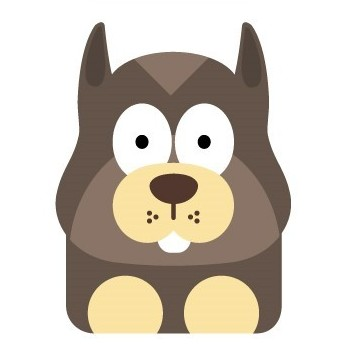

In [7]:
# the avatars contains all the avatars image
# open each avatar, and encode to base64
filename_list = os.listdir('./raw_data/avatars')
full_filename_list = [os.path.join('./raw_data/avatars', filename) for filename in filename_list]

avatars = []
for full_filename in full_filename_list:
    with open(full_filename, 'rb') as f:
        avatar = base64.b64encode(f.read()).decode('utf-8')

        # add the data:image/jpg;base64
        avatar = f"data:image/jpg;base64,{avatar}"
        avatars.append(avatar)

print(avatars[0])

In [8]:
with app.app_context():
    db.drop_all()
    db.create_all()

    # insert student url, leave resume_url as empty
    # open ./raw_data/student.txt and read into database
    with open('./raw_data/student.txt', 'r') as f:
        for line in f:
            line = line.strip()

            # each line are: username, first_name, last_name, email, password, qualification, school_name, major, skills, strength
            tokens = line.split('|')

            new_student = Student(
                username=tokens[0],
                first_name=tokens[1],
                last_name=tokens[2],
                email=tokens[3],
                password=tokens[4],
                avatar=random.choice(avatars),
                qualification=tokens[5],
                school_name=tokens[6],
                major=tokens[7],
                skills=tokens[8],
                strength=tokens[9],
                resume_url=None)

            db.session.add(new_student)

        db.session.commit()

    # fill supervisor table, read the file ./raw_data/supervisor.txt
    with open('./raw_data/supervisor.txt', 'r') as f:
        for line in f:
            line = line.strip()

            # each line are: username, first_name, last_name, email, password, qualification, school_name, skills
            tokens = line.split('|')

            new_supervisor = Supervisor(
                username=tokens[0],
                first_name=tokens[1],
                last_name=tokens[2],
                email=tokens[3],
                password=tokens[4],
                avatar=random.choice(avatars),
                qualification=tokens[5],
                school_name=tokens[6],
                skills=tokens[7])

            db.session.add(new_supervisor)

        db.session.commit()

    # fill partner table, read the file ./raw_data/partner.txt
    with open('./raw_data/partner.txt', 'r') as f:
        for line in f:
            line = line.strip()

            # each line are: username, first_name, last_name, email, password, company, position, description
            tokens = line.split('|')

            new_partner = Partner(
                username=tokens[0],
                first_name=tokens[1],
                last_name=tokens[2],
                email=tokens[3],
                password=tokens[4],
                avatar=random.choice(avatars),
                company=tokens[5],
                position=tokens[6],
                description=tokens[7])

            db.session.add(new_partner)

        db.session.commit()

    # create all the fake projects, total 30 projects
    # open the file ./raw_data/project.txt and read in all the projects.
    # example:
    # Title: Automated Drone Delivery System
    # Description: Develop an automated system to facilitate the delivery of packages using drones.
    # Problem Statement: The traditional delivery system is slow, labor-intensive, and can't cater to remote areas efficiently.
    # Desired Outcomes: A fully functional prototype drone capable of carrying packages up to 5kg, equipped with an automated routing system.
    # Required Skills: Robotics, Machine Learning, Aerial Dynamics, Routing Algorithms.
    # Deliverables: Prototype drone, backend control system, user interface for package tracking, and documentation.
    # (here will be an empty line)

    # here we get all students, partners, and supervisors
    all_students = Student.query.all()
    all_partners = Partner.query.all()
    all_supervisors = Supervisor.query.all()

    with open('./raw_data/project.txt', 'r') as f:
        # read all lines, strip
        lines = f.readlines()
        lines = [line.strip() for line in lines]

        # each project has 7 lines
        for i in range(0, len(lines), 7):
            title = lines[i].split(':')[1].strip()
            description = lines[i + 1].split(':')[1].strip()
            problem_statement = lines[i + 2].split(':')[1].strip()
            desired_outcomes = lines[i + 3].split(':')[1].strip()
            required_skills = lines[i + 4].split(':')[1].strip()
            deliverables = lines[i + 5].split(':')[1].strip()

            # fake a datetime between July
            # this is the project.created_at time
            created_at = faker.date_time_between_dates(
                start_date=datetime(2023, 7, 1),
                end_date=datetime(2023, 7, 31),
                tzinfo=timezone)

            # create a new project
            new_project = Project(
                # randomly select one partner
                partner_id=random.choice(all_partners).partner_id,
                title=title,
                description=description,
                problem_statement=problem_statement,
                desired_outcomes=desired_outcomes,
                required_skills=required_skills,
                deliverables=deliverables,
                created_at=created_at,
                status='is_open')

            db.session.add(new_project)

        db.session.commit()

    # select the all projects, and set the first half projects to be completed
    all_projects = Project.query.all()
    all_completed_projects = all_projects[:len(all_projects) // 2]

    # read all student interest express,
    # and read in all supervisor interest express
    student_interest_express_list = []
    supervisor_interest_express_list = []

    with open('./raw_data/student_interest_express.txt', 'r') as f:
        student_interest_express_list = f.readlines()
        student_interest_express_list = [line.strip() for line in student_interest_express_list]

    with open('./raw_data/supervisor_interest_express.txt', 'r') as f:
        supervisor_interest_express_list = f.readlines()
        supervisor_interest_express_list = [line.strip() for line in supervisor_interest_express_list]

    # for each finished project,
    # need to complete the table: project, student_interest_express, supervisor_interest_express
    # project_progress, and random project supervisor feedback
    for this_complete_project in all_completed_projects:
        # select random 5 students, and 3 supervisors to express interest
        # reason last_updated_at is within 8/1 to 8/15
        # select random 3 supervisors to express interest
        # reason last_updated_at is within 8/1 to 8/15
        interest_student_list = random.choices(all_students, k=5)
        interest_supervisor_list = random.choices(all_supervisors, k=3)

        for interest_student in interest_student_list:
            reason = random.choice(student_interest_express_list)

            last_update_at = faker.date_time_between_dates(
                start_date=datetime(2023, 8, 1),
                end_date=datetime(2023, 8, 15),
                tzinfo=timezone)

            new_student_interest_express = StudentInterestExpress(
                student_id=interest_student.student_id,
                project_id=this_complete_project.project_id,
                reason=reason,
                last_updated_at=last_update_at)

            db.session.add(new_student_interest_express)


        for interest_supervisor in interest_supervisor_list:
            reason = random.choice(supervisor_interest_express_list)

            last_update_at = faker.date_time_between_dates(
                start_date=datetime(2023, 8, 1),
                end_date=datetime(2023, 8, 15),
                tzinfo=timezone)

            new_supervisor_interest_express = SupervisorInterestExpress(
                supervisor_id=interest_supervisor.supervisor_id,
                project_id=this_complete_project.project_id,
                reason=reason,
                last_updated_at=last_update_at)

            db.session.add(new_supervisor_interest_express)

        # the project table: fill: supervisor_id, being assigned at, student id, being assigned at
        # select the final project_student and proejct_supervisor from the interest list
        project_student = random.choice(interest_student_list)
        project_supervisor = random.choice(interest_supervisor_list)

        # this all happens at 8.16 - 8.20
        being_assigned_at = faker.date_time_between_dates(
            start_date=datetime(2023, 8, 16),
            end_date=datetime(2023, 8, 20),
            tzinfo=timezone)

        this_complete_project.supervisor_id = project_supervisor.supervisor_id
        this_complete_project.supervisor_being_assigned_at = being_assigned_at
        this_complete_project.student_id = project_student.student_id
        this_complete_project.student_being_assigned_at = being_assigned_at

        # since it is completed, mark this project as closed
        this_complete_project.status = 'closed'

        # commit everything so far
        db.session.commit()

        # each project will







